# MJO analysis with unfied TDE

In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using Pkg
Pkg.add("DelayEmbeddings")

    Updating registry at `C:\Users\lisah\.julia\registries\General.toml`
   Resolving package versions...
      Compat entries added for 
  No Changes to `C:\Users\lisah\Documents\Repos\enso_project.jl\Project.toml`
  No Changes to `C:\Users\lisah\Documents\Repos\enso_project.jl\Manifest.toml`


In [3]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project, JLD2, DelayEmbeddings

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


In [4]:
header = ["year", "month", "day", "hour", "PC1 coeff", "PC2 coeff", "PC1+PC2 amplitude"]
data = CSV.read("data/mjo_data/mjo_romi.txt", DataFrame; delim=" ", ignorerepeated=true, header=header)

pc1 = data[!,"PC1 coeff"]
pc2 = data[!,"PC2 coeff"]
amp = data[!, "PC1+PC2 amplitude"];

In [5]:
# only embedds PC2
unified_data = StateSpaceSet(pc1, pc2, amp)
Y_pecu, τ_vals_pecu, ts_vals_pecu, Ls, εs = pecuzal_embedding(unified_data)

Initializing PECUZAL algorithm for multivariate input...
Starting 1-th embedding cycle...
Starting 2-th embedding cycle...
Starting 3-th embedding cycle...
Starting 4-th embedding cycle...
Starting 5-th embedding cycle...
Starting 6-th embedding cycle...
Starting 7-th embedding cycle...
Starting 8-th embedding cycle...
Algorithm stopped due to increasing L-values. VALID embedding achieved ✓.


(8-dimensional StateSpaceSet{Float64} with 12562 points, [0, 13, 7, 10, 27, 21, 41, 34], [2, 2, 2, 2, 2, 2, 2, 2], [-0.001839927760191512, -0.1466043697132447, -0.08161150880551948, -0.05640641089185526, -0.10520331048308537, -0.04260407975040101, -0.04296166254296904], [[1.2872521799072547 0.0021239342349629988 0.8252399526152054; 1.282160994477721 0.20721353714830604 0.8497457548743683; … ; 1.276439017407599 1.2358166474013412 1.2440871190409857; 1.2785249303568869 1.2364753136507873 1.243737001909017] [0.9878038329750911 0.043329993113138544 0.7649539128308718; 0.9664901959070771 0.19320812964669065 0.7799364560183553; … ; 1.2396681563430918 1.2100487056993376 1.242291126065108; 1.2431450681374843 1.2172483643428178 1.241961023470586] … [0.856964484398566 0.28123191555314003 0.7715869890761738; 0.8438912343506744 0.28516187671814164 0.7641694872264836; … ; 0.9418247509380488 0.9637798286897664 1.0536129946791863; 0.9346920579739555 0.9978006220712899 1.0656546982899089] [0.833247093

In [37]:
# embedded training data of pc2
pc2_emb = Matrix(transpose(Matrix(Y_pecu)));

In [36]:
# put data of pc1, pc2 together for unified training
pc1 = pc1[1:size(data_pc2_emb,2)] # crop pc1 to suitable length

# first row is pc1 original time series, second row is pc2 original time series
data = vcat(permutedims(pc1), pc2_emb)

9×12562 Matrix{Float64}:
  0.12526   0.18542   0.2396   0.27446  …   0.34968   0.34431   0.33045
 -0.06945  -0.04887  -0.03933  0.0199       0.56867   0.49267   0.43295
  0.31856   0.30929   0.33681  0.36904     -0.32039  -0.27262  -0.21293
  0.34553   0.41978   0.45432  0.44696     -0.14853  -0.20038  -0.25173
  0.44696   0.44401   0.39319  0.31856     -0.25259  -0.28836  -0.36453
  1.24032   1.20034   1.19385  1.21125  …  -0.0233    0.02671   0.02144
  0.96613   1.09647   1.20131  1.24241     -0.00988  -0.04641  -0.04137
  0.30136   0.21646   0.14469  0.13614     -0.40887  -0.38871  -0.34477
  1.01386   0.91302   0.85056  0.78449      0.00233  -0.04809  -0.16275

In [40]:
test_size = 100
train_size = Int(floor(size(data,2)* 0.8))
val_size = size(data,2) - test_size - train_size

data_train = data[:, 1:train_size]
data_val = data[:, train_size+1:train_size+val_size]
data_test = data[:, train_size+val_size+1:train_size+val_size+test_size];

In [41]:
spectral_radii = [0.8,0.9,1.0]
sparsities = [0.14,0.1,0.5]
input_scales = [0.1,1.0]
ridge_values = [0.0,1e-5, 1e-6]
reservoir_sizes = [500,700,1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)

esn, W_out, val_loss = enso_project.cross_validate_esn(data_train, data_val, param_grid)

enso_project.ESNHyperparams(500, 0.8, 0.14, 0.1, 0.0)
Validation loss = 15747.092594239602
enso_project.ESNHyperparams(700, 0.8, 0.14, 0.1, 0.0)
Validation loss = 15600.583579249314
enso_project.ESNHyperparams(700, 0.8, 0.14, 0.1, 1.0e-5)
Validation loss = 15600.313049662946


(ESN(9 => 700), OutputLayer successfully trained with output size: 9, 15600.313049662946)

In [43]:
function esn_eval_pred_mjo(esn::ESN, W_out, test_data::Matrix, emb_dim_pc1::Int64)
    steps_to_predict = size(test_data,2)
    prediction = esn(Generative(steps_to_predict), W_out)
    return prediction[[1, emb_dim_pc1 +1],:]
end

prediction = esn_eval_pred_mjo(esn, W_out, data_test, 1)

2×100 Matrix{Float64}:
 -0.962     -1.00649  -1.04966   …  -0.118862  -0.194075  -0.264565
 -0.320808  -0.50782  -0.579931      0.454963   0.459999   0.460703

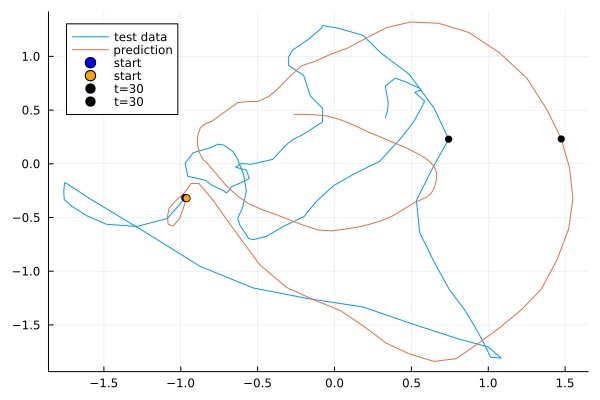

In [44]:
plot(data_test[1,:], data_test[2,:], label="test data")
plot!(prediction[1,:], prediction[2,:], label="prediction")
scatter!([data_test[1,1]], [data_test[2,1]], label="start", color=:blue, marker=:circle, markersize=4)
scatter!([prediction[1,1]], [prediction[2,1]], label="start", color=:orange, marker=:circle, markersize=4)
scatter!([data_test[1,30]], [data_test[2,30]], label="t=30", color=:black, marker=:circle, markersize=4)
scatter!([prediction[1,30]], [prediction[2,30]], label="t=30", color=:black, marker=:circle, markersize=4)

In [46]:
# store esn for later purposes
@save "C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/esn_saves/mjo_unified_tde_pecuzal.jld2" mjo_unified_tde_pecuzal=esn
@save "C:/Users/lisah/Documents/Repos/enso_project.jl/temp_saves/esn_saves/mjo_unified_tde_pecuzal_W.jld2" mjo_unified_tde_pecuzal_W=W_out